# Importing the Libraries



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the dataset

In [2]:
dataset = pd.read_csv("IMDB Dataset.csv")
dataset.head()
dataset.isnull().values.any()

dataset.shape

(50000, 2)

# Cleaning the data

In [3]:
import re

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [4]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [5]:
X = []
sentences = list(dataset['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [6]:
print(X[3])

Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them 


In [7]:
Y = dataset['sentiment']

# when review is positive make it =1 , when it is negative make it =0
Y = np.array(list(map(lambda x: 1 if x=="positive" else 0, Y)))

# Splitting the data

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=0)

# Tokenization

In [9]:
#extract tokens from the text the number of tokens is 5000
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train)

In [10]:
# convert the text to a numeric sequence 
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [11]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

print('Found %s unique tokens.' % vocab_size)

Found 92285 unique tokens.


In [12]:
#max length of sequence
from keras.preprocessing.sequence import pad_sequences
maxlen = 256
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [13]:
# importing the dictionary of words 'glove.6B.200d'
from numpy import asarray
embeddings_dictionary = dict()
glove_file = open('./glove.6B.200d.txt', encoding="utf8")

for line in glove_file:
    records = line.split(' ')
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [14]:
from numpy import zeros
embedding_matrix = zeros((vocab_size, 200))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# Building the LSTM model

In [15]:
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers.embeddings import Embedding
from keras.layers import Flatten, LSTM

model = Sequential()
embedding_layer = Embedding(vocab_size, 200,
                            weights=[embedding_matrix],
                            input_length=maxlen ,
                            trainable=False)
model.add(embedding_layer)
model.add(LSTM(128,return_sequences=True,dropout=0.5))
model.add(LSTM(32,dropout=0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam',
              loss = 'mean_squared_error',
              metrics=['acc'])

In [16]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 200)          18457000  
_________________________________________________________________
lstm (LSTM)                  (None, 256, 128)          168448    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 18,646,089
Trainable params: 189,089
Non-trainable params: 18,457,000
_________________________________________________________________
None


# Training the model

In [17]:
trained_model = model.fit(X_train, Y_train, batch_size=128, epochs = 25, verbose=1, shuffle=False,validation_data=(X_test,Y_test))
score = model.evaluate(X_test, Y_test, verbose=1)

Epoch 1/25
313/313 [==============================] - 435s 1s/step - loss: 0.2471 - acc: 0.5272 - val_loss: 0.2411 - val_acc: 0.5620
Epoch 2/25
313/313 [==============================] - 426s 1s/step - loss: 0.2322 - acc: 0.6011 - val_loss: 0.1677 - val_acc: 0.7757
Epoch 3/25
313/313 [==============================] - 427s 1s/step - loss: 0.1428 - acc: 0.8038 - val_loss: 0.1350 - val_acc: 0.8123
Epoch 4/25
313/313 [==============================] - 428s 1s/step - loss: 0.1159 - acc: 0.8385 - val_loss: 0.1019 - val_acc: 0.8595
Epoch 5/25
313/313 [==============================] - 432s 1s/step - loss: 0.1072 - acc: 0.8514 - val_loss: 0.1108 - val_acc: 0.8502
Epoch 6/25
313/313 [==============================] - 425s 1s/step - loss: 0.1013 - acc: 0.8590 - val_loss: 0.1035 - val_acc: 0.8536
Epoch 7/25
313/313 [==============================] - 425s 1s/step - loss: 0.0973 - acc: 0.8661 - val_loss: 0.0960 - val_acc: 0.8713
Epoch 8/25
313/313 [==============================] - 428s 1s/step - 

#Confusion matrix

In [18]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
cm =confusion_matrix(y_pred, Y_test)
cm
print(classification_report(y_pred,Y_test))

              precision    recall  f1-score   support

       False       0.86      0.94      0.90      4629
        True       0.94      0.87      0.91      5371

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.91      0.90      0.90     10000



In [19]:
results = model.evaluate(X_test,Y_test,batch_size=128)

79/79 [==============================] - 34s 436ms/step - loss: 0.0736 - acc: 0.9020


# Learning Curves

In [20]:
def plot_learningCurve(trained_model, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, trained_model.history['acc'])
  plt.plot(epoch_range, trained_model.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, trained_model.history['loss'])
  plt.plot(epoch_range, trained_model.history['val_loss'])

  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

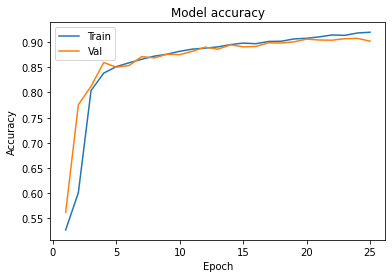

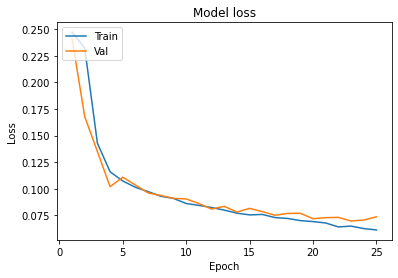

In [21]:
plot_learningCurve(trained_model, 25)

In [22]:
from sklearn.metrics import precision_score , recall_score, f1_score
print(f1_score(Y_test,y_pred))
print('f1------')
print(recall_score(Y_test,y_pred))
print('RECAL------')
print(precision_score(Y_test,y_pred))
print('PRECISION------')

0.9051857585139319
f1------
0.942195367573011
RECAL------
0.870973747905418
PRECISION------
